In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.nn import functional as F

from typing import List, Callable, Union, Any, TypeVar, Tuple
# from torch import tensor as Tensor
Tensor = TypeVar('torch.tensor')
from PIL import Image  
import os

import datetime
# epoch=100 kl=0.01 loss=0.02005288349568844 这个的模型结构
class VAE_CNN_01(nn.Module):
    def __init__(self, latent_dim):
        super(VAE_CNN, self).__init__()
        self.latent_dim = latent_dim
        in_channels = 3

        hidden_dims =  [32, 64, 128, 256, 512] 
        

        
        # 构建编码器
        modules = []
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1], latent_dim)

        #构建解码器
        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1])
        hidden_dims.reverse() # 转置数组！！
        modules = []
        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )
        self.decoder = nn.Sequential(*modules)


        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= 3,
                                      kernel_size= 3, padding= 1),
                            nn.Tanh())
    
    def encode(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)
        # print("encode中flatten后的result.shape: ", result.shape)
        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    
    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        # print("decode中z.shape: ", z.shape)
        result = self.decoder_input(z)
        # print("decode中的result.shape: ", result.shape)
        result = result.view(-1, 512, 1, 1) # kjl在这里做了修改
        # print("decode中view后的result.shape: ", result.shape)
        result = self.decoder(result)
        # print("decode中decoder后的result.shape: ", result.shape)
        result = self.final_layer(result)
        # print("decode中final_layer后的result.shape: ", result.shape)
        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input: Tensor, **kwargs):
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return  self.decode(z), input, mu, log_var

# 定义VAE模型
class VAE_CNN(nn.Module):
    def __init__(self, latent_dim):
        super(VAE_CNN, self).__init__()
        self.latent_dim = latent_dim
        in_channels = 3

        hidden_dims =  [32, 64, 128, 256] 
        
        # 构建编码器
        modules = []
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1]*4, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*4, latent_dim)

        #构建解码器
        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1]*4)
        hidden_dims.reverse() # 转置数组！！
        modules = []
        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )
        self.decoder = nn.Sequential(*modules)


        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= 3,
                                      kernel_size= 3, padding= 1),
                            nn.Tanh())
    
    def encode(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)
        # print("encode中flatten后的result.shape: ", result.shape)
        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    
    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        # print("decode中z.shape: ", z.shape)
        result = self.decoder_input(z)
        # print("decode中的result.shape: ", result.shape)
        result = result.view(-1, 256, 2, 2) # kjl在这里做了修改
        # print("decode中view后的result.shape: ", result.shape)
        result = self.decoder(result)
        # print("decode中decoder后的result.shape: ", result.shape)
        result = self.final_layer(result)
        # print("decode中final_layer后的result.shape: ", result.shape)
        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input: Tensor, **kwargs):
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return  self.decode(z), input, mu, log_var


# 官方的vae损失
def vae_loss_official(x, x_recon, mu, logvar, device, kl_weight):
    recons_loss =F.mse_loss(x_recon, x)
    kl_loss = torch.mean(-0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp(), dim = 1), dim = 0)
    loss = recons_loss + kl_weight * kl_loss
    return loss

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

# 自定义datasets
class Mydata_sets(Dataset):
    def __init__(self, path, transform=None):
        super(Mydata_sets, self).__init__()
        self.root_dir = path
        self.img_names = os.listdir(self.root_dir)
        self.img_names.sort(key = lambda x:int(x[4:-4]))
        self.transform = transform

    def __getitem__(self, index):
        img_name = self.img_names[index]
        img = Image.open(os.path.join(self.root_dir, img_name))
        id_name = torch.tensor(int(img_name[4:-4])) #pic_xx.jpg
        if self.transform is not None:
            img = self.transform(img)
        return img, id_name

    def __len__(self):
        return len(self.img_names)

# 设置训练参数
latent_dim = 2
batch_size = 128
epochs = 200
lr = 1e-3
kl_weight = 0.000001
device = torch.device("cuda:0")

# 加载数据集
train_dataset = Mydata_sets('./static/data/CIFAR10/pic/random_50k_png', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

# 初始化VAE模型和优化器
vae = VAE_CNN(latent_dim)
vae = vae.to(device)
optimizer = optim.Adam(vae.parameters(), lr=lr)


# 训练VAE模型
vae.train()
for epoch in range(epochs):
    total_loss = 0
    for batch_idx, (x, id_number) in enumerate(train_loader):
        optimizer.zero_grad()

        x = x.to(device)
        x_recon, x, mu, logvar = vae(x)

        loss = vae_loss_official(x, x_recon, mu, logvar, device, kl_weight)
        
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader.dataset)}")

# 关键参数信息
title = "epoch = " + str(epochs) + " kl = " + str(kl_weight) + " loss = " + str(total_loss / len(train_loader.dataset)) + " batch_size = " + str(batch_size)

time = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
torch.save(vae.state_dict(), "./临时垃圾-随时可删/20230825vae带卷积训练/vae_state_dict_"+ title + " " + time + ".pt")

Epoch 1/200, Loss: 0.005360498068332672
Epoch 2/200, Loss: 0.004973853776454926
Epoch 3/200, Loss: 0.004928743374347687
Epoch 4/200, Loss: 0.004901372102499009
Epoch 5/200, Loss: 0.004881518596410751
Epoch 6/200, Loss: 0.004856216207742691
Epoch 7/200, Loss: 0.004829728256464005
Epoch 8/200, Loss: 0.004803331285715104
Epoch 9/200, Loss: 0.004787866818904877
Epoch 10/200, Loss: 0.004773159643411636
Epoch 11/200, Loss: 0.00476056890964508
Epoch 12/200, Loss: 0.004745968061685562
Epoch 13/200, Loss: 0.004734371771812439
Epoch 14/200, Loss: 0.004729983631372452
Epoch 15/200, Loss: 0.00472147116780281
Epoch 16/200, Loss: 0.004721416690349579
Epoch 17/200, Loss: 0.00470209077835083
Epoch 18/200, Loss: 0.004695904115438462
Epoch 19/200, Loss: 0.004691995990276337
Epoch 20/200, Loss: 0.004682317752838135
Epoch 21/200, Loss: 0.004675985339879989
Epoch 22/200, Loss: 0.004664963414669037
Epoch 23/200, Loss: 0.004655303511619568
Epoch 24/200, Loss: 0.004658473596572876
Epoch 25/200, Loss: 0.004650

In [2]:
# 降维
# vae = VAE_CNN(2)
# vae_path = "./临时垃圾-随时可删/20230825vae带卷积训练/vae_state_dict_epoch = 200 kl = 0.01 loss = 0.019542265374660493 batch_size = 32 2023-08-25 20:18:12.pt"
# title = "vae_state_dict_epoch = 200 kl = 0.01 loss = 0.019542265374660493 batch_size = 32"
# vae.load_state_dict(torch.load(vae_path, map_location=device))
# vae = vae.to(torch.device("cuda:0"))

vae.eval()
# 加载数据集
train_dataset = Mydata_sets('./static/data/CIFAR10/pic/random_50k_png', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

for batch_idx, (x, id_number) in enumerate(train_loader):
    x = x.to(device)
    ans = vae.encode(x)
    mu, log_var = ans[0], ans[1]
    z = vae.reparameterize(mu, log_var)
    if batch_idx == 0:
        zs = z
    else:
        zs = torch.cat((zs, z), dim=0)
print(zs.shape)

torch.Size([50000, 2])


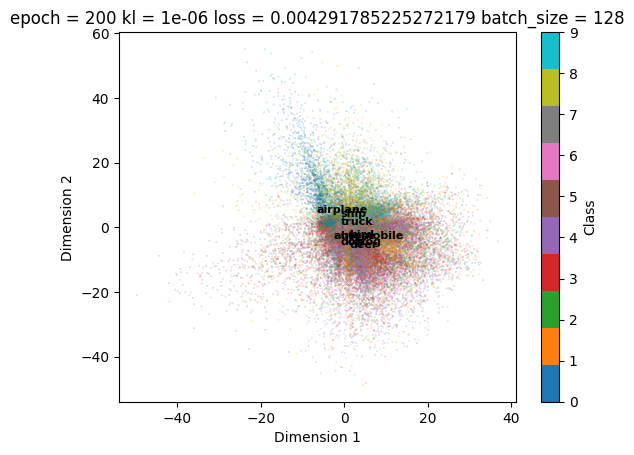

In [3]:
# 绘制散点图

import torch
import numpy as np
import matplotlib.pyplot as plt

labels = torch.load("./临时垃圾-随时可删/labels.pt")
cifar10_labels = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

# 将张量转换为 NumPy 数组
zs_np = zs.to(torch.device("cpu")).detach().numpy()
# zs_np = zs_np[:5000]
# labels = labels[:5000]

# 获取类别数量和颜色映射
color_map = plt.get_cmap("tab10")

# 绘制散点图
plt.scatter(zs_np[:, 0], zs_np[:, 1], s=0.01, c=labels, cmap=color_map)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title(title)
plt.colorbar(label="Class")

# 添加类别标签
for i in range(10):
    label = cifar10_labels[i]
    x = zs_np[labels == i, 0].mean()
    y = zs_np[labels == i, 1].mean()
    plt.text(x, y, label, fontsize=8, ha='center', va='center', weight='bold')
plt.show()

<Figure size 640x480 with 0 Axes>

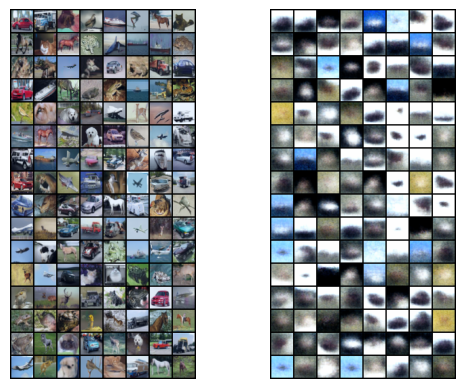

In [4]:
import torch
import torchvision
import matplotlib.pyplot as plt

for batch_idx, (x, id_number) in enumerate(train_loader):
    plt.clf()

    x = x.to(device)
    ans = vae.encode(x)
    mu, log_var = ans[0], ans[1]
    z = vae.reparameterize(mu, log_var)
    recon = vae.decode(z)
   
    # 两个形状为（32，3，32，32）的随机图像张量
    image_tensor1 = x.detach().cpu()
    image_tensor2 = recon.detach().cpu()
    
    # 创建一个图像网格，以便在单个图像中显示第一个张量的图像
    grid_img1 = torchvision.utils.make_grid(image_tensor1, nrow=8, normalize=True)

    # 创建一个图像网格，以便在单个图像中显示第二个张量的图像
    grid_img2 = torchvision.utils.make_grid(image_tensor2, nrow=8, normalize=True)

    # 将第一个图像张量转换为NumPy数组
    image_np1 = grid_img1.permute(1, 2, 0).numpy()

    # 将第二个图像张量转换为NumPy数组
    image_np2 = grid_img2.permute(1, 2, 0).numpy()

    # 创建一个包含两个子图的图像窗口
    fig, axes = plt.subplots(1, 2)

    # 在第一个子图中显示第一个图像
    axes[0].imshow(image_np1)
    axes[0].axis('off')

    # 在第二个子图中显示第二个图像
    axes[1].imshow(image_np2)
    axes[1].axis('off')

    # 调整子图之间的间距
    plt.subplots_adjust(wspace=0.1)

    # 显示图像窗口
    plt.show()

    a = input("输入y继续")
    if a == "y" or a == "Y":
        continue
    else:
        break
